In [1]:
%load_ext autoreload
%autoreload 2

# Clase Tutorial 7: MLP & Backpropagation


Existen varios frameworks que permiten desarrollar redes neuronales con facilidad, como son TensorFlow y PyTorch. Sin embargo, en esta clase comenzaremos programando una red neuronal desde cero para obtener un mayor entendimiento y una mejor intuición sobre como funcionan los algoritmos. En particular, vamos a implementar un perceptrón multicapa para resolver tareas de clasificación solamente usando NumPy para hacer cálculos matemáticos.

## Redes Neuronales

- Supongamos que queremos predecir el precio de una vivienda dado el tamaño de esta. 
- Nuestro objetivo es introducir un valor de entrada $x$ en una función $h(x)$ que devuelva el precio de la vivienda $y$. 
$$h: x \rightarrow y$$ 
- Una de las redes neuronales más simples sería definir $h(x)$ como una sola “neurona” en la red, donde: 
    - $h(x) = \max(ax + b, 0)$, para algunos coeficientes $a$ y $b$. 
    - En el contexto de redes neuronales, esta función se llama __ReLU__, o unidad lineal rectificada. 

- Una red neuronal más compleja puede tomar la neurona simple descrita anteriormente y “apilar” varias de ellas de manera que una neurona pase su salida como entrada a la siguiente neurona, resultando en una función más compleja. 

    - Es análogo a armar estructuras con Legos: tomas bloques individuales y los apilas para construir estructuras complejas. Para las redes, tomamos neuronas individuales y las apilamos para crear redes neuronales complejas.

- Ahora profundicemos en el ejemplo de predicción de viviendas. Además del tamaño de la casa, supongamos que conocemos el número de dormitorios, el código postal y el capital del barrio. Dadas estas features, podríamos decidir que el precio de la casa depende de:

    - El __tamaño máximo de la familia__ que puede habitarla. Se podría pensar como una función del _tamaño de la casa_ y del _número de dormitorios_. 
    - Cuán __caminable__ es el barrio (es decir, ¿podes caminar hasta el almacén o necesitas manejar a todas partes?). Se podría pensar que el código postal puede proporcionar esta información
    - La __calidad de la escuela primaria__ de la zona. Se podría pensar como una función del _código postal_ con el _capital_ del barrio. 

    Entonces podríamos concluir que el precio de la casa depende en última instancia de estas tres características derivadas. 

    <img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/img1.jpg" alt="image" style="display: block; margin: 0 auto; max-width: 50%; height: auto;">



- Lo que hicimos fue describir la red neuronal como si ya tuvieramos la intuición de que estos tres factores finalmente afectan el precio de una casa. 
- Pero parte de la "magia" de una red neuronal es que solo entregándole las características de entrada $x$ y la salida $y$, se encarga de descubrir todo lo que sucede en el medio. (Lo único que debemos proporcionarle es una cantidad suficiente de ejemplos de entrenamiento $(x^{(i)}, y^{(i)})$). 
    - A este proceso de aprendizaje de características intermedias se le llama __"end-to-end learning"__. 

- Muchas veces, la red neuronal va a descubrir características complejas que son muy útiles para predecir la salida, pero que pueden ser difíciles de entender para una persona, ya que no tienen un significado "común". 
    - Por eso, algunas personas se refieren a las redes neuronales como una caja negra, ya que puede ser difícil entender las características que ha inventado.

### Formalizando

- Supongamos que tenemos:
    - 3 características de entrada $x_1, x_2, x_3$, que colectivamente se llaman la __capa de entrada__
    - 4 neuronas/unidades ocultas que conforman la __capa oculta__, y 
    - 1 neurona de salida llamada la __capa de salida__. 
    
    _NOTA: El término capa oculta se llama "oculta" porque no tenemos el valor real o de entrenamiento para las unidades ocultas. Esto es diferente de las capas de entrada y salida, donde conocemos los valores reales de $(x^{(i)}, y^{(i)})$._

- La primera unidad oculta necesita como entrada $x_1, x_2, x_3$ y devuelve un valor denotado por $z_1$. 
- En este ejemplo en particular, tenemos una única capa oculta, pero es posible tener varias capas ocultas. 
- Denotamos $z^{[1]}_1$ como el valor de salida de la primera unidad oculta en la primera capa oculta. 
    - Usamos indexación en cero para referirnos a los números de capa. Es decir, la capa de entrada es la capa 0, la primera capa oculta es la capa 1 y la capa de salida es la capa 2. 
    - Dada esta notación, la salida de la capa 2 es $z^{[2]}_1$. 

- Para aclarar: 
    - $foo^{[1]}$ con _corchetes_ denota cualquier cosa asociada con la _capa_ 1, 
    - $x^{(i)}$ con _paréntesis_ se refiere al i-ésimo _ejemplo de entrenamiento_, y 
    - $z^{[\ell]}_j$ se refiere a la activación de la j-ésima unidad en la capa $\ell$. 

    Si vemos la regresión logística $g(x)$ como una única neurona:

    $$ g(x) = \frac{1}{1 + e^{-\theta^Tx}}$$

    <img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/img2.png" alt="image" style="display: block; margin: 0 auto; max-width: 50%; height: auto;">

    - Donde la entrada de la regresión logística son las 3 features $x_1, x_2, x_3$ y su salida es una estimación del valor de $y$. 
    - Podemos representar a $g(x)$ como una sola neurona, y descomponerla en dos cálculos distintos:

        1. $a = w^T x + b$  
        2. $z = \sigma(a) = \frac{1}{1 + e^{-a}}$.

    - Notar la diferencia de notación: anteriormente usamos $a = \theta^T x$, pero ahora estamos usando $a = w^T x + b$, donde $w$ es un vector. Más adelante, usaremos la letra mayúscula $W$ para denotar una matriz.
    - Si generalizamos, $z = g(a)$ donde $g(a)$ es alguna función de activación (no lineal). Ejemplos de funciones de activación incluyen:

    $$g(z) = \frac{1}{1 + e^{-z}} \quad (\text{sigmoide})$$  
    $$g(z) = \max(z, 0) \quad (\text{ReLU})$$  
    $$g(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} \quad (\text{tanh})$$

- Volviendo a nuestra red neuronal anterior, la primera unidad oculta en la primera capa oculta realizará el siguiente cálculo:

    $$a^{[1]}_1 = W^{[1]T}_1 x + b^{[1]}_1$$  

    $$z^{[1]}_1 = g(a^{[1]}_1)$$

    donde $W$ es una matriz de parámetros y $W_1$ se refiere a la primera fila de esta matriz.  

- Los parámetros asociados a la primera unidad oculta son el vector $W^{[1]}_1 \in \mathbb{R}^3$ y el escalar $b^{[1]}_1 \in \mathbb{R}$. 

- Para la segunda y tercera unidad oculta en la primera capa oculta, el cálculo está definido como:

    $$a^{[1]}_2 = W^{[1]T}_2 x + b^{[1]}_2;\text{   } a^{[1]}_3 = W^{[1]T}_3 x + b^{[1]}_3  $$  
    $$z^{[1]}_2 = g(a^{[1]}_2);\text{   } z^{[1]}_3 = g(a^{[1]}_3)$$

    donde cada unidad oculta tiene sus correspondientes parámetros $W$ y $b$.  

- Siguiendo, la capa de salida realiza el cálculo:

    $$a^{[2]}_1 = W^{[2]T}_1 z^{[1]} + b^{[2]}_1$$  
    $$z^{[2]}_1 = g(a^{[2]}_1)$$

    donde $z^{[1]}$ se define como la concatenación de todas las activaciones de la primera capa:

    $$z^{[1]} = \begin{bmatrix} z^{[1]}_1 \\ z^{[1]}_2 \\ z^{[1]}_3 \\ z^{[1]}_4 \end{bmatrix}$$

- La activación $z^{[2]}_1$ de la segunda capa, que es un escalar único definido por $z^{[2]}_1 = g(a^{[2]}_1)$, representa la predicción final de la red neuronal. 

    _NOTA: para tareas de regresión, típicamente no se aplica una función no lineal que sea estrictamente positiva (como ReLU o sigmoide), ya que en algunos casos el valor real de $y$ puede ser negativo._


## Vectorización

- Para calcular las activaciones de las unidades ocultas en la primera capa, tenemos que calcular:

$$a^{[1]}_1 = W^{[1]T}_1 x + b^{[1]}_1 \quad \dots \quad a^{[1]}_4 = W^{[1]T}_4 x + b^{[1]}_4$$  
 
$$z^{[1]}_1 = g(a^{[1]}_1) \quad \dots \quad z^{[1]}_4 = g(a^{[1]}_4)$$

- La forma más natural de implementar esto en código sería usar un bucle `for`. Sin embargo, uno de los grandes aportes del deep learning al campo del machine learning es que los algoritmos de deep learning tienen altos requisitos computacionales. Como resultado, el código se ejecutará muy lentamente si se utilizan bucles `for`.

- En lugar de usar bucles, la vectorización aprovecha el álgebra matricial para hacer que los cálculos en redes neuronales se ejecuten rápidamente. 


- Usando álgebra matricial, podemos calcular las preactivaciones:


$$
a^{[1]} = W^{[1]}x + b^{[1]}
$$

$$
\begin{bmatrix}
a^{[1]}_1 \\
\vdots \\
a^{[1]}_4
\end{bmatrix}
=
\begin{bmatrix}
W^{[1]T}_1 \\
W^{[1]T}_2 \\
\vdots \\
W^{[1]T}_4
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
+
\begin{bmatrix}
b^{[1]}_1 \\
b^{[1]}_2 \\
\vdots \\
b^{[1]}_4
\end{bmatrix}
$$

$$
\left[\mathbb{R}^{4 \times 1}\right] = \left[\mathbb{R}^{4 \times 3}\right]\left[\mathbb{R}^{3 \times 1}\right] + \left[\mathbb{R}^{4 \times 1}\right]
$$

- Para calcular $z^{[1]}$ sin un bucle `for`, podemos aprovechar las bibliotecas vectorizadas de Python, las cuales calculan $z^{[1]} = g(a^{[1]})$ muy rápido realizando operaciones elemento a elemento en paralelo. 

#### 🤔 ¿Por qué no usamos la función identidad para $g(z)$ (es decir, $g(z) = z$)?


- Supongamos que $b^{[1]}$ y $b^{[2]}$ son ceros. Si computamos la preactivacion de la capa de salida, tenemos:

    $$
    a^{[2]} = W^{[2]}z^{[1]} = W^{[2]}g(a^{[1]}) = W^{[2]}a^{[1]} = W^{[2]}W^{[1]}x = \tilde{W}x
    $$

- Observen cómo $W^{[2]}W^{[1]}$ se colapsó en $\tilde{W}$. Esto ocurre porque aplicar una función lineal a otra función lineal resulta en una función lineal sobre el input original (es decir, podemos construir un $\tilde{W}$ tal que $\tilde{W}x = W^{[2]}W^{[1]}x$). 
- Esto pierde gran parte del poder representacional de la red neuronal, ya que muchas veces la salida que estamos tratando de predecir tiene una relación no lineal con las entradas. 

➡️ Sin funciones de activación no lineales, la red neuronal simplemente realizaría una regresión lineal.


#### Vectorización sobre ejemplos de entrenamiento

- Supongamos que tenemos un conjunto de entrenamiento con tres ejemplos. Las preactivaciones para cada ejemplo son las siguientes:

    $$
    a^{[1](1) } = W^{[1]}x^{(1)} + b^{[1]} \\
    a^{[1](2) } = W^{[1]}x^{(2)} + b^{[1]} \\
    a^{[1](3) } = W^{[1]}x^{(3)} + b^{[1]}
    $$

    ❗ _Tener en cuenta la diferencia entre los corchetes $[ \cdot ]$, que se refieren al número de capa, y los paréntesis $( \cdot )$, que se refieren al número de ejemplo de entrenamiento._

- Para vectorizar estas operaciones, apilamos los ejemplos de entrenamiento en columnas (no en filas):

    $$
    X =
    \begin{bmatrix}
    | & | & | \\
    x^{(1)} & x^{(2)} & x^{(3)} \\
    | & | & |
    \end{bmatrix}
    $$

- De esta forma, podemos combinar esto en una sola formulación unificada:

$$
A^{[1]} =
\begin{bmatrix}
| & | & | \\
a^{[1](1) } & a^{[1](2) } & a^{[1](3) } \\
| & | & |
\end{bmatrix}
= W^{[1]}X + b^{[1]}
$$

Resumiendo: 
- Supongamos que tenemos un conjunto de entrenamiento $(x^{(1)}, y^{(1)}), \dots , (x^{(m)}, y^{(m)})$, donde $x^{(i)}$ es una imagen y $y^{(i)}$ es una etiqueta binaria que indica si la imagen contiene un gato o no (es decir, $1 =$ contiene un gato).

1. Inicializamos los parámetros $W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]}$ con números aleatorios pequeños. 
2. Para cada ejemplo, calculamos la “probabilidad” de salida usando la función sigmoide $z^{[2](i)}$. Usando la función de log-verosimilitud de la regresión logística:

$$
\sum_{i=1}^{m} \left( y^{(i)} \log z^{[2](i)} + (1 - y^{(i)}) \log (1 - z^{[2](i)}) \right)
$$

3. Entrenamos la red neuronal. En este caso, correspondería a maximizar esta función utilizando ascenso por gradiente.

Un modelo de red neuronal consiste en dos componentes:
1. La arquitectura: definimos cuantas capas, cuantas neuronas y cómo se conectan.
2. Los parámetros: los valores o pesos de la red. 

A continuación vamos a hablar sobre cómo aprender estos parámetros.

## Parámetros de la red

Consideremos la siguiente red neuronal "fully connected" (todas las neuronas de la capa $\ell-1$ están conectadas a todas las neuronas de la capa $\ell$. )

<img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/img3.jpg" alt="image" style="display: block; margin: 0 auto; max-width: 50%; height: auto;">

#### 🤔 ¿Cuántos parámetros tiene esta red?

Para calcular cuántos parámetros hay en esta red, podemos calcular la propagación hacia adelante manualmente.

$$
a^{[1]} = W^{[1]} x^{(i)} + b^{[1]}
$$
$$
z^{[1]} = g(a^{[1]})
$$
$$
a^{[2]} = W^{[2]} z^{[1]} + b^{[2]}
$$
$$
z^{[2]} = g(a^{[2]})
$$
$$
a^{[3]} = W^{[3]} z^{[2]} + b^{[3]}
$$
$$
\hat{y}^{(i)} = z^{[3]} = g(a^{[3]})
$$

Sabemos que $a^{[1]}, z^{[1]} \in \mathbb{R}^{3 \times 1}$, $a^{[2]}, z^{[2]} \in \mathbb{R}^{2 \times 1}$, y $a^{[3]}, az^{[3]} \in \mathbb{R}^{1 \times 1}$. 

Para calcular el tamaño de $W^{[1]}$, sabemos que $x \in \mathbb{R}^{n \times 1}$. Esto nos lleva a lo siguiente:

$$ 
a^{[1]} = W^{[1]}x{(i)} = \mathbb{R}^{3 \times 1}
$$
 
Escrito como tamaños: $\mathbb{R}^{3 \times 1} = \mathbb{R}^{? \times ?} \cdot \mathbb{R}^{n \times 1}$.

- Concluimos que $W^{[1]}$ debe ser $3 \times n$ y que $b^{[1]}$ debe ser $3 \times 1$.

Repetimos este proceso para cada capa oculta. Esto nos da:

- $W^{[2]}$ debe ser $2 \times 3$ y $b^{[2]}$ debe ser $2 \times 1$.
- $W^{[3]}$ debe ser $1 \times 2$ y $b^{[3]}$ debe ser $1 \times 1$.

En total, tenemos $3n + 3$ en la primera capa, $2 \times 3 + 2$ en la segunda capa y $2 + 1$ en la tercera capa. 

➡️ Esto nos da un total de $3n + 14$ parámetros.

### Inicialización de parámetros

- Es necesario inicializar los parámetros de la red neuronal para poder comenzar a entrenarla con descenso por gradiente.

- Después de una sola pasada hacia adelante por la red neuronal, la salida será un valor predicho $\hat{y}$. Luego, podemos calcular la pérdida $L$. 

- Dado este valor, ahora debemos actualizar todos los parámetros en las capas de la red neuronal. Para cualquier índice de capa $\ell$, actualizamos los parámetros de la siguiente manera:

    $$
    W^{[\ell]}_{new} = W^{[\ell]}_{old} - \alpha \frac{\partial L}{\partial W^{[\ell]}}
    $$
    $$
    b^{[\ell]}_{new} = b^{[\ell]}_{old} - \alpha \frac{\partial L}{\partial b^{[\ell]}}
    $$

    donde $\alpha$ es la tasa de aprendizaje/learning rate. 
    
- Para proceder, debemos calcular el gradiente con respecto a los parámetros: $\frac{\partial L}{\partial W^{[\ell]}}$ y $\frac{\partial L}{\partial b^{[\ell]}}$.

#### 1. 🤔 ¿Qué pasa si inicializamos todos los parámetros a con un mismo valor?

- Las activaciones de la primera capa serían:

    $$
    z^{[1]} = g(a^{[1]}) = g(W^{[1]}x^{(i)} + b^{[1]})
    $$

    donde todos los elementos de $W^{[1]}$ tienen el mismo valor.

- Lo mismo ocurriría para todas las capas de la red neuronal.

- Cuando calculemos el gradiente durante backpropagation, todas las neuronas en una capa serán igualmente responsables de lo que contribuya a la pérdida final.

- Esto se conoce como __simetría__: cada neurona (dentro de una capa) recibirá exactamente el mismo valor de actualización de gradiente (es decir, todas las neuronas aprenderán lo mismo). 

- Entonces esta arquitectura podría ser comprimida a una estructura mucho más simple (una sola neurona en cada capa). Esta arquitectura solamente nos permitirá resolver problemas lineales.

#### 2. 🤔 ¿Qué pasa si inicializamos todos los parámetros a cero?

- La salida de la última capa evaluaría a 0:   
    $$
        a^{[3]} = W^{[3]}z^{[2]}+b^{[3]} = 0_{1 \times 2}z^{[2]} + 0_{1 \times 1}
    $$
    donde $0_{n \times m}$ denota una matriz de tamaño $n \times m$ llena de ceros. 

- Sin embargo, la salida de la red neuronal está definida como $z^{[3]} = g(a^{[3]})$, y si $g(\cdot)$ está definida como la función sigmoide:

$$
z^{[3]} = g(0) = 0.5
$$

➡️ Por lo tanto, sin importar el valor de $x^{(i)}$ que proporcionemos, la red producirá $\hat{y} = 0.5$.

#### 3. 🤔 ¿Qué pasa si inicializamos los parámetros con valores muy altos o muy bajos?

__Valores muy altos:__

- Exploding gradients: Los gradientes pueden explotar durante la retropropagación. 
- Esto ocurre porque, en redes profundas, los pesos grandes hacen que las derivadas crezcan exponencialmente al propagarse hacia atrás, resultando en actualizaciones inestables y saltos grandes en la función de costo, lo que puede hacer que el modelo no converja o diverja.

__Valores muy bajos:__

- Vanishing gradients: Los gradientes pueden desvanecerse. 
- Los pesos pequeños tienden a hacer que las derivadas se reduzcan al propagarse hacia atrás, causando que las actualizaciones sean mínimas y que el aprendizaje sea extremadamente lento. 
- La red puede quedarse "estancada" sin hacer progreso hacia un mínimo en la función de costo.

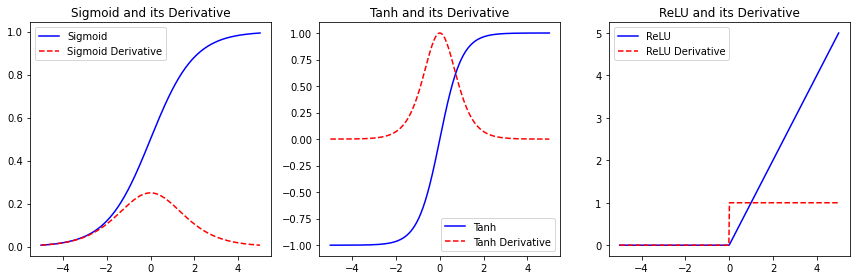

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x > 0, 1, 0)

x = np.linspace(-5, 5, 400)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(x, sigmoid(x), label='Sigmoid', color='blue')
axs[0].plot(x, sigmoid_deriv(x), label='Sigmoid Derivative', color='red', linestyle='--')
axs[0].set_title('Sigmoid and its Derivative')
axs[0].legend()

axs[1].plot(x, tanh(x), label='Tanh', color='blue')
axs[1].plot(x, tanh_deriv(x), label='Tanh Derivative', color='red', linestyle='--')
axs[1].set_title('Tanh and its Derivative')
axs[1].legend()

axs[2].plot(x, relu(x), label='ReLU', color='blue')
axs[2].plot(x, relu_deriv(x), label='ReLU Derivative', color='red', linestyle='--')
axs[2].set_title('ReLU and its Derivative')
axs[2].legend()

plt.tight_layout()
plt.show()

#### 🤔 Entonces, ¿Cuál es la forma correcta de inicializar los parámetros?
 
- Para funciones de activación como sigmoide o tanh, se suele usar la inicialización __Xavier/Glorot__:

    $$
    \mathcal{N}(0, \sqrt{\frac{2}{n_{in} + n_{out}}} )
    $$

- Para funciones de activación como la ReLU, se suele usar la inicialización __He__:

    $$
    \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}} )
    $$

En general, las dos inicializaciones anteriores funcionan muy bien cuando se tienen redes con muchas capas ocultas. Si se tiene una red con pocas capas ocultas ("shallow"), otra variantes posibles son:

- Para sigmoid y tanh: $$ \mathcal{U}(-\sqrt{\frac{6}{n_{in}+ n_{out}}},\sqrt{\frac{6}{n_{in}+ n_{out}}})$$ 

- Para ReLU: $$ \mathcal{U}(-\sqrt{\frac{6}{n_{in}}},\sqrt{\frac{6}{n_{in}}})$$ 


En cuanto al sesgo/bias, se configuran típicamente en valores positivos pequeños para asegurar que la mayoría de las preactivaciones estén activas inicialmente durante el aprendizaje.

- Esto es especialmente útil con las unidades ReLU, donde queremos que las preactivaciones sean positivas para que haya un gradiente no nulo que impulse el aprendizaje.

Para más info sobre el tema, recomiendo leer: https://www.deeplearning.ai/ai-notes/initialization/index.html

## 🤔 ¿Cómo "aprende" un MLP?

A muy alto nivel, el procedimiento de aprendizaje sigue la siguiente secuencia de pasos:

* Inicializamos los parámetros
* Elegimos algoritmo de optimización 
* Repetimos:
    1. Propagación hacia adelante del input
    2. Cálculo de función de pérdida
    3. Cálculo de gradientes de la función de pérdida respecto a los parámetros usando backpropagation
    4. Actualización de cada parámetro usando los gradientes (según el algoritmo de optimización).

    ```
    for e = 1, ..., epochs:
        for b = 1 ...batchs:
            1. ⏩ Forward Pass 
            2. ⏮️ Backward Pass 
            3. 🔁 Update model weights (to minimize L)
    ```

### 🤔 Pero ... ¿Qué significa "epoch" y "batch"?

<img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/img4.webp" alt="image" style="display: block; margin: 0 auto; max-width: 30%; height: auto;">

#### __Epoch__

- Un epoch es una iteración completa a través de todo el conjunto de datos de entrenamiento. 
- En otras palabras, durante un epoch, el modelo ha visto y actualizado sus parámetros usando cada muestra del conjunto de entrenamiento una vez. 
- Si tenemos un dataset con 1000 ejemplos y entremos nuestro modelo durante 10 epochs, significa que el modelo ha pasado por esos 1000 ejemplos 10 veces.

#### __Batch__

- Un batch (o lote) es un subconjunto del conjunto de datos completo. 
- En lugar de usar todas las muestras del dataset para actualizar los parámetros del modelo en cada epoch, se divide el conjunto de datos en varios batches más pequeños. 
- Cada batch se usa para calcular una actualización de los parámetros del modelo. Esto se hace para hacer el proceso de entrenamiento más manejable y eficiente en términos de computo y memoria.
- Si tenemos un dataset con 1000 ejemplos y decidimos usar un batch size de 100, entonces dividiríamos los datos en 10 batches, cada uno con 100 ejemplos. 
- El modelo actualizará sus parámetros después de cada batch.

##### Batch Size
- El tamaño del batch afecta al balance entre la calidad de las actualizaciones de los parámetros y la eficiencia computacional. 
- El tamaño suele estar limitado por la memoria disponible en la GPU o CPU que estás utilizando.
    - Se suele eligir como una potencia de 2 (16, 32, 64, 128, 256...) porque este tamaño es más eficiente en el procesamiento de GPUs.
- Batch size chico (~ 16/32):
    - Introducen más ruido en las actualizaciones de los parámetros porque están basados en menos muestras de datos. 
    - Pueden ayudar a escapar de mínimos locales pero también pueden ralentizar la convergencia.

- Batch size grande (~ 128/256):
    - Proporcionan una mejor estimación del gradiente real porque consideran más ejemplos.
    - Necesitan más memoria y hay menos actualizaciones por época.

### 🤔 ¿Que es Gradient Descent?

* Es un algoritmo de optimización iterativo de primer orden para encontrar el mínimo de una función.
* Su objetivo es minimizar la función de costo de la red neuronal.
* Para lograrlo, tiene dos pasos iterativos:
    1. Calcular el gradiente (derivada de primer orden) de la función en un punto
    2. Moverse en la dirección opuesta del aumento de la pendiente desde es punto actual por una distancia computada
    
    <img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/gradient-descent.webp" alt="image" style="display: block; margin: 0 auto; max-width: 50%; height: auto;">

* Entonces, el objetivo es pasar el set de entrenamiento a través de las capas ocultas de la red, y luego ajustar los parámetros de las capas computando los gradientes usando los ejemplos de entrenamiento.

### Variantes del Gradient Descent 

Dependiendo de cómo se utilizan los batches, hay varias variantes del gradiente descendente:

**Batch Gradient Descent** (Batch size = tamaño del dataset):

- Solo actualiza los pesos al final de cada época.
- Puede ser costoso en términos de memoria y tiempo.
- Pérdida suave, pero riesgo de quedar atascado en mínimos locales.

**Stochastic Gradient Descent (SGD)** (Batch size = 1):

- Actualiza los pesos después de cada ejemplo.
- Introduce mucho ruido, lo que puede dificultar la convergencia.
- Recomendado solo para casos específicos.

**Mini-Batch Gradient Descent** (Batch size > 1 pero < tamaño del dataset):

- Combina lo mejor de ambos métodos: actualizaciones más frecuentes y uso eficiente de los recursos de cómputo.
- Proporciona un equilibrio entre ruido y precisión.

<img src="/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/images/GD.jpg" alt="image" style="display: block; margin: 0 auto; max-width: 50%; height: auto;">


## Implementación de una MLP para clasificación

Encapsularemos la implementación del perceptrón multicapa dentro de una clase llamada `MLP` dentro de `models.py`

Para implementar una instancia de la clase debera:

```
from models import MLP
model = MLP(layers=[n_input,n_hidden,n_output],
            activations=["relu","sigmoid"])
```

## Ejemplo de uso

### 📊 Dataset: Wine Quality

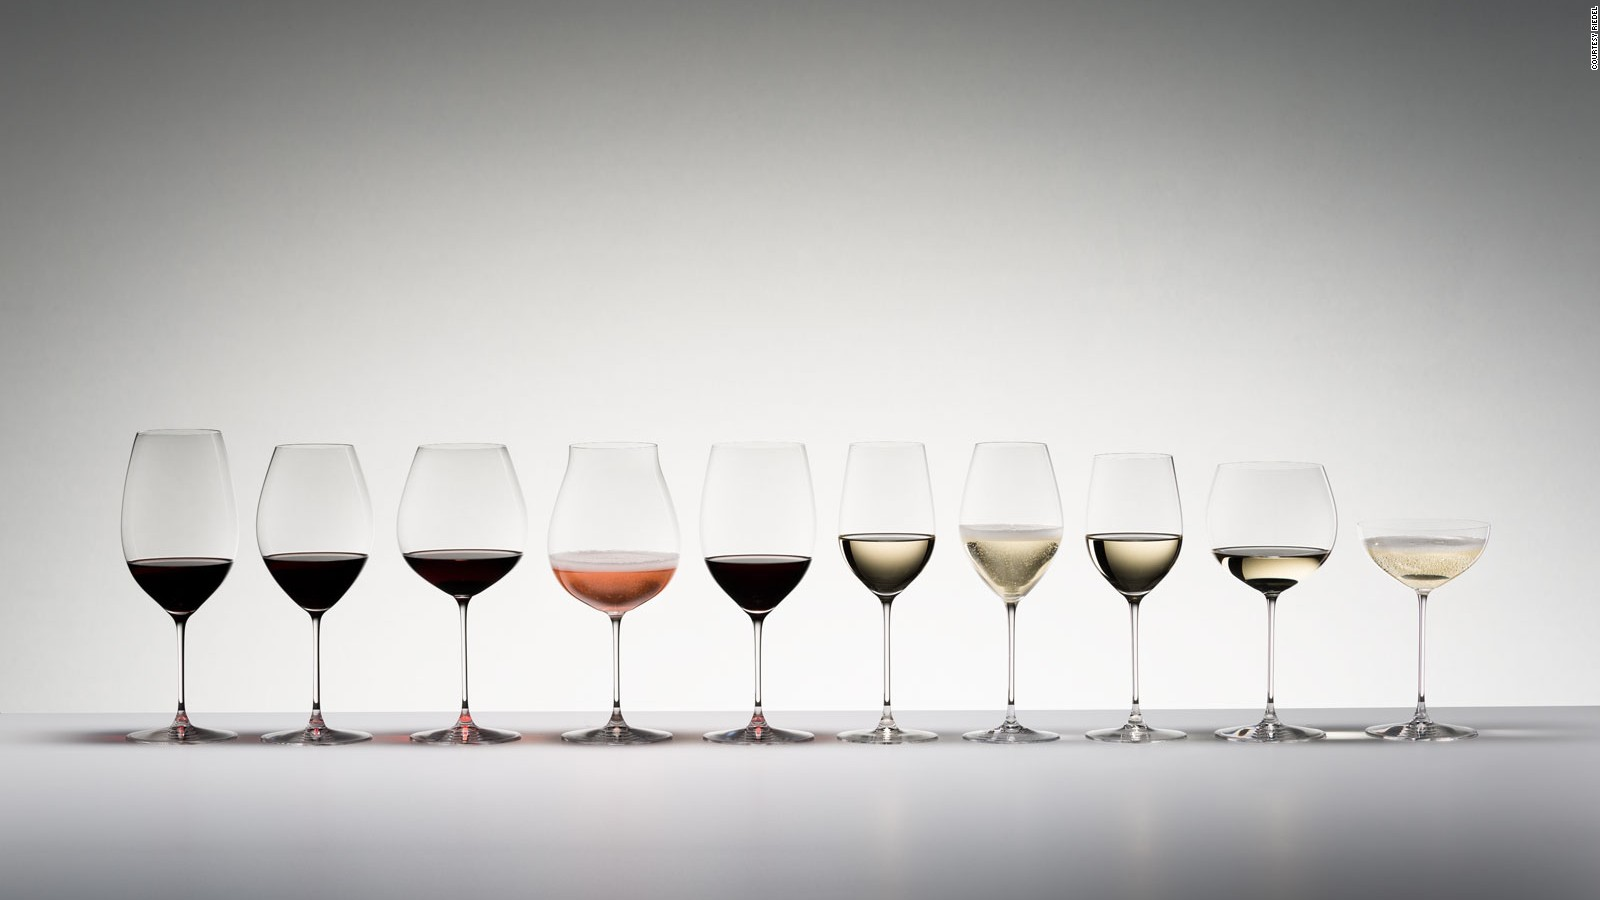

Fuente del dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from models import MLP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

df = pd.read_csv("/home/linar/Desktop/ML/Clases/i302/Clases/07_Clase 7: MLPs & Backpropagations/Data/winequality-red.csv")

In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


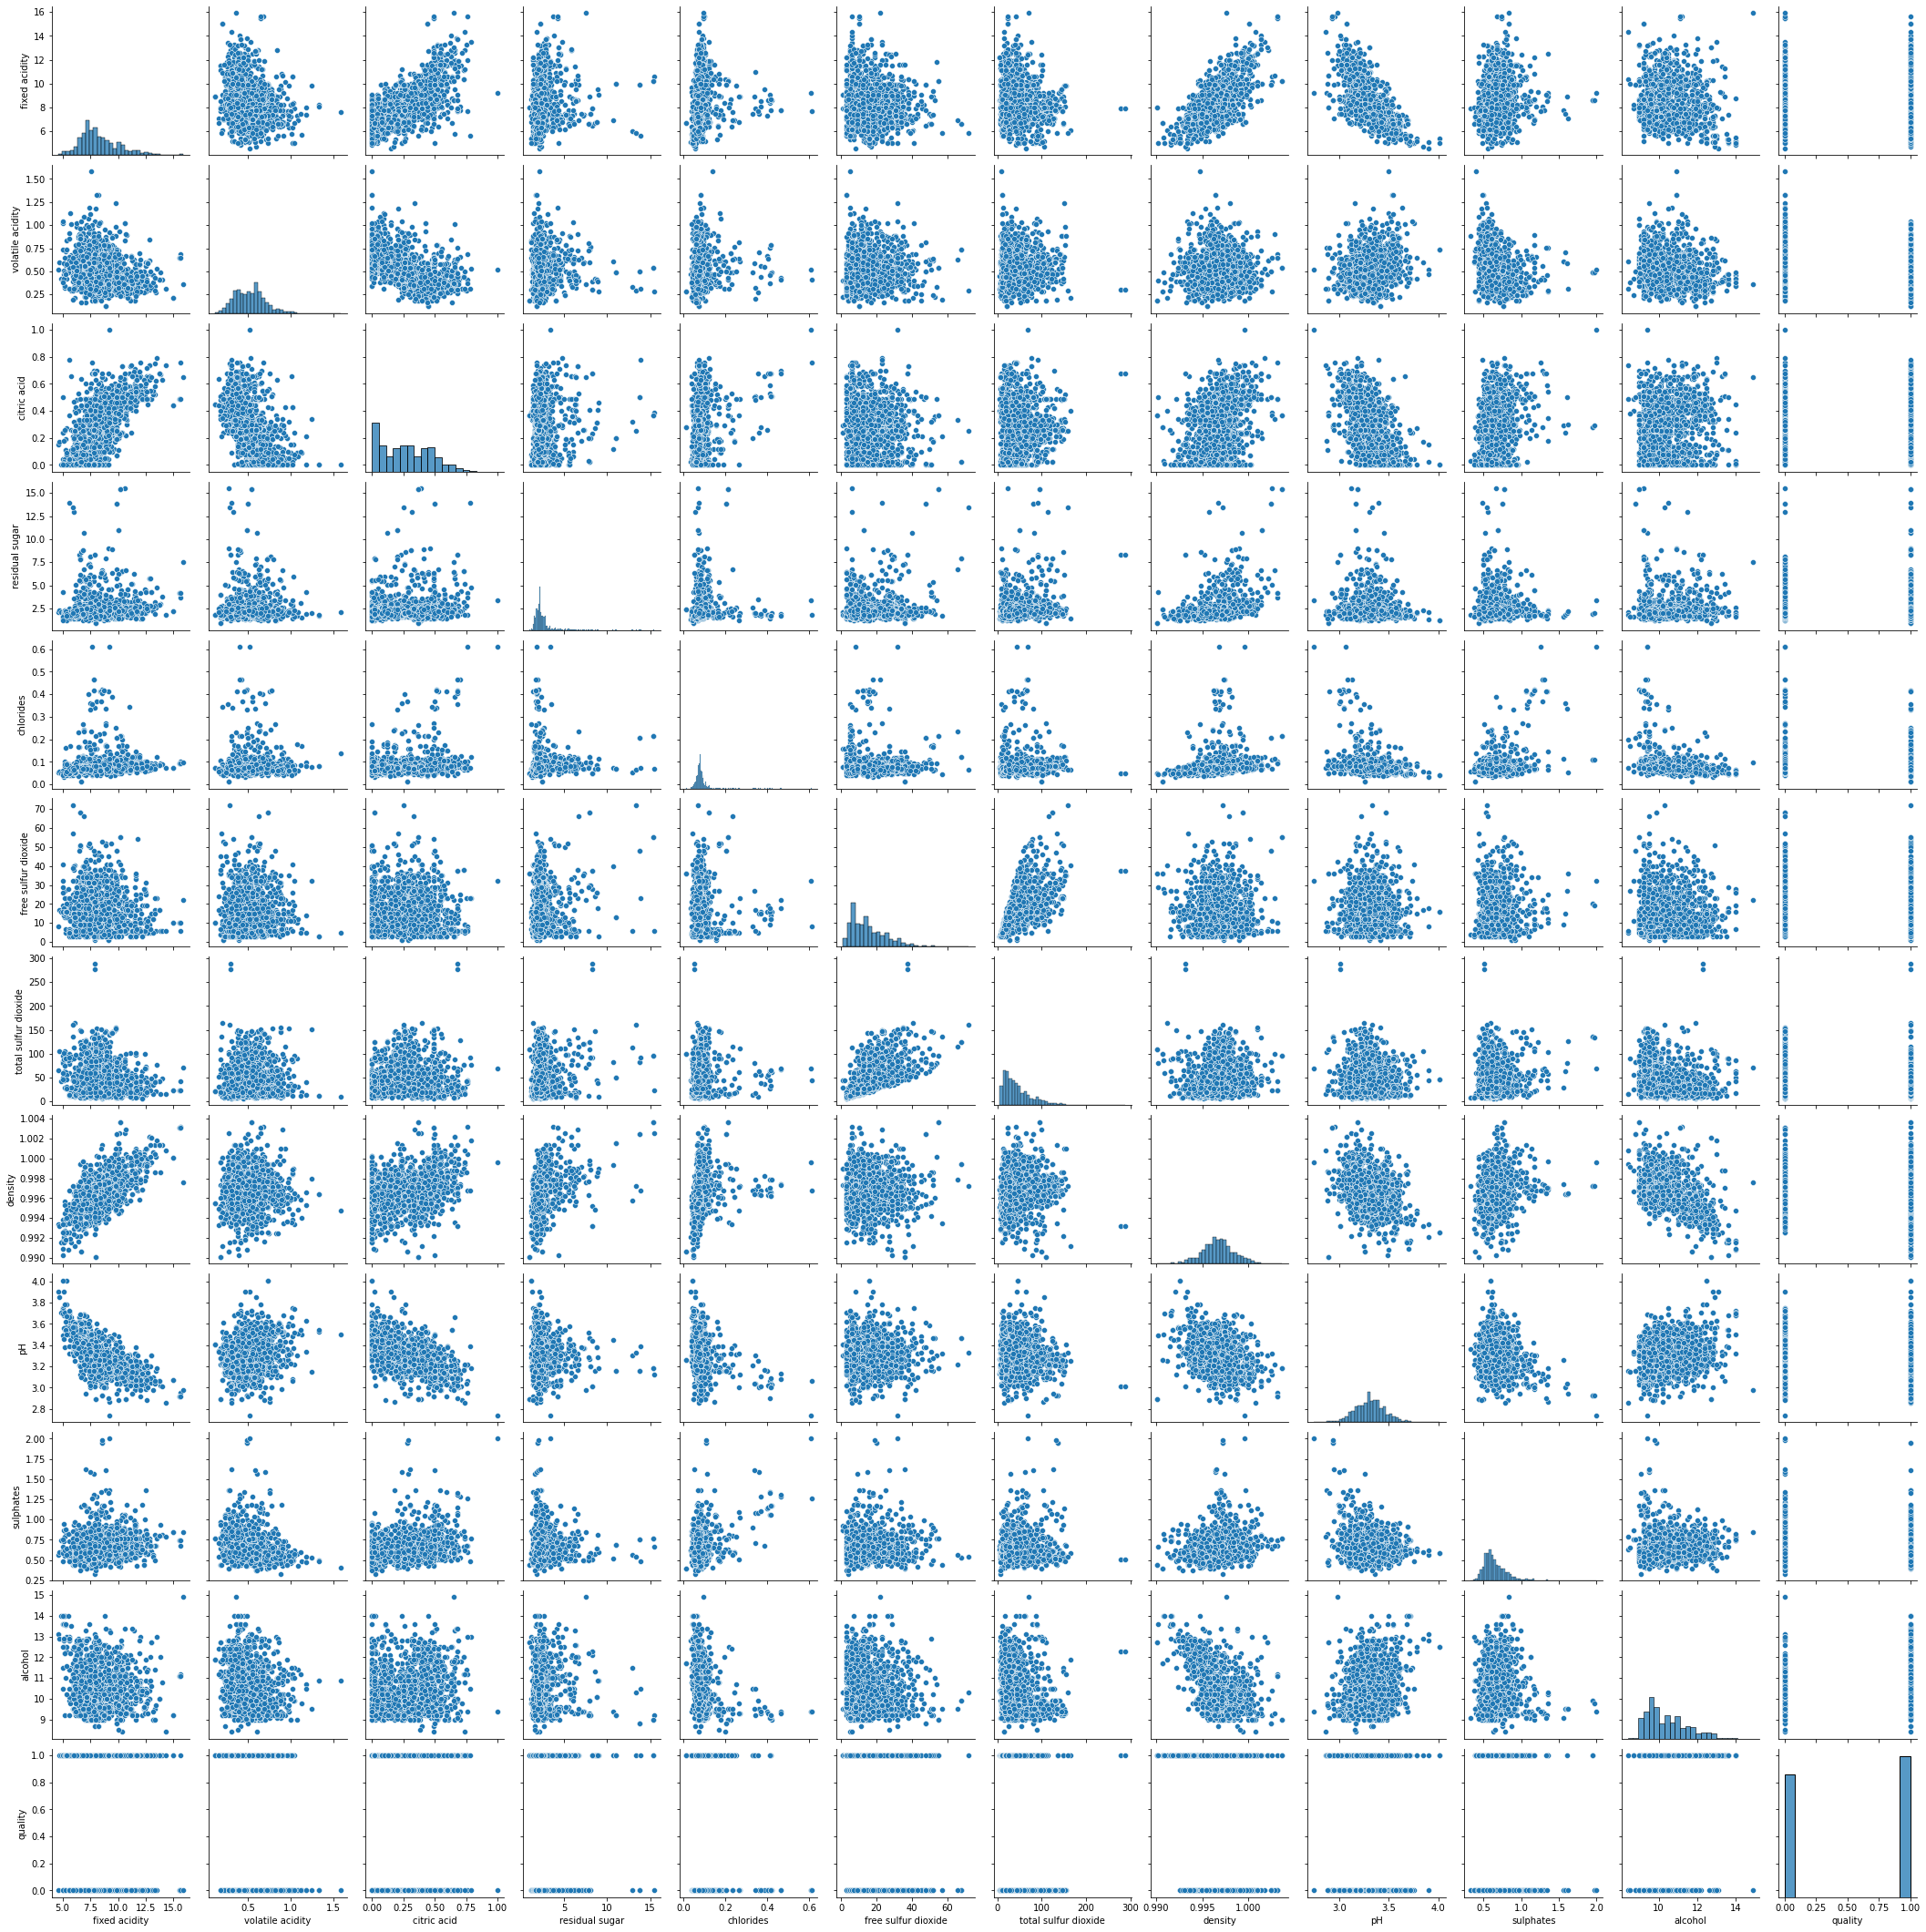

In [12]:
sns.pairplot(df)

In [ ]:
# Convert into a binary classification problem (quality <= 5 as class 0, quality > 5 as class 1)
df['quality'] = (df['quality'] > 5).astype(int)

# Prepare dataset
X = df.drop(columns=['quality']).values
y = df['quality'].values.reshape(-1, 1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the MLP
training_data = list(zip(X_train, y_train))
testing_data = list(zip(X_test, y_test))

### 👩🏻‍💻 Creamos MLP 

In [4]:
mlp = MLP(layers=[11, 10, 1], 
          activations=["relu", "sigmoid"], 
          verbose=True)

### 💪 Entrenamos

In [5]:
mlp.fit(training_data, 
        epochs=250, 
        mini_batch_size=64, 
        lr=0.01, 
        val_data=testing_data, 
        verbose=0)

Training Epochs: 100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


([0.9855674166293433,
  0.6345710379588277,
  0.6171058700732506,
  0.5894105275634182,
  0.5816279957324128,
  0.6222014642719395,
  0.543040623922559,
  0.5526770014313995,
  0.5356545751494649,
  0.5393605910088101,
  0.5210288340203736,
  0.523851131921053,
  0.5123418568142507,
  0.5199201009141758,
  0.5166819408808928,
  0.5084162054852728,
  0.5012524460109263,
  0.5090809372913383,
  0.5012012008984054,
  0.5108021596565491,
  0.5002044942576281,
  0.4964413244850724,
  0.49965941939484126,
  0.49300668483256516,
  0.4916427829459001,
  0.49058579051844536,
  0.48649449329746003,
  0.4848734772530093,
  0.48745387745619684,
  0.48377692606768863,
  0.4796023126072547,
  0.48427662158605267,
  0.4827593404735426,
  0.4789535527985163,
  0.4776938747151612,
  0.48735262733100215,
  0.47164514987034156,
  0.47240760630187506,
  0.47228256448885303,
  0.47044565550286144,
  0.4665595104747144,
  0.4761748486175157,
  0.46902688674474025,
  0.46658684422261254,
  0.4649041068285373

### 🎯 Generamos las predicciones

In [6]:
# Predict on test data
predictions = mlp.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

### 📈 Evaluamos las métricas

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       141
           1       0.79      0.78      0.79       179

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



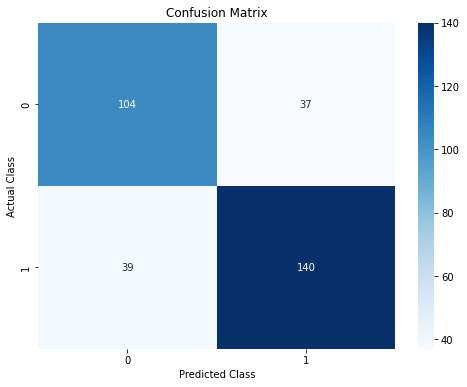

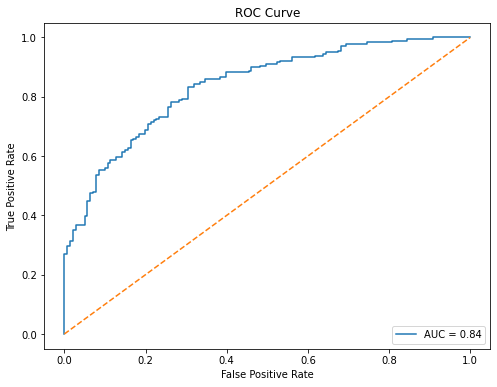

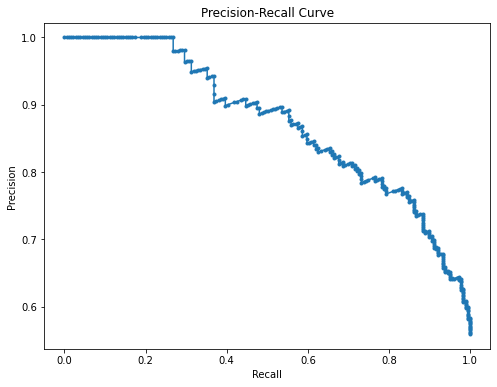

In [7]:
# Print classification report
print(classification_report(y_test, predicted_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### ⚖️ Comparamos con [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       141
           1       0.79      0.78      0.79       179

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



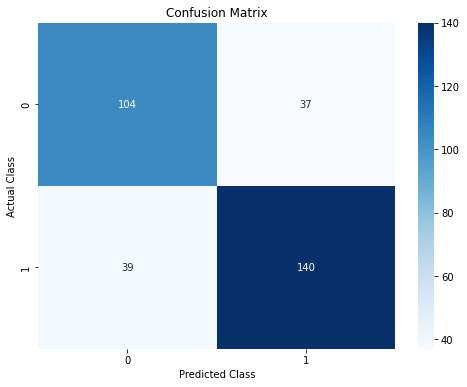

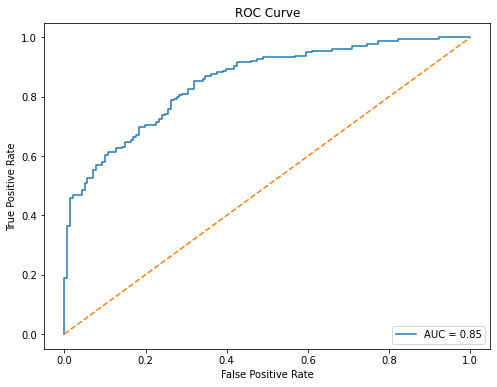

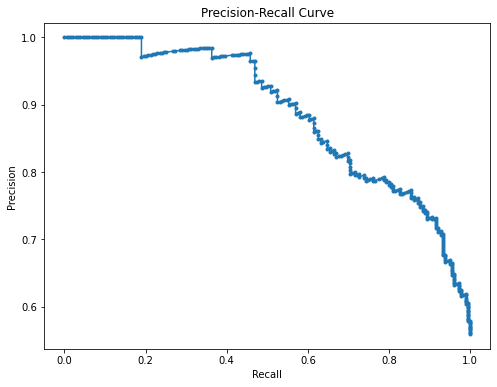

In [8]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,), 
                    activation='relu', 
                    solver='sgd', 
                    batch_size=64,
                    learning_rate_init=0.01,
                    max_iter=250, 
                    random_state=42)
mlp.fit(X_train, y_train.ravel())

# Predict on test data
predictions = mlp.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
predicted_classes = mlp.predict(X_test)

# Print classification report
print(classification_report(y_test, predicted_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()